# Random Forest

In this notebook, we will discuss our second classification model predicting recidivism - Random Forest. 

## Outline

* [Packages](#Packages)
* [Data Import & Scaling](#Data-Import-and-Hypertuning)
* [Logistic Regression - Modeling and Hyperparametertuning](#Logistic-Regression-Modeling)
* [Confusion Matrix](#Confusion-Matrix)
* [ROC and AUC Score](#ROC-AUC)
* [Model-Specific Feature Importance (Gini Impurity)](#Gini)
* [Partial Dependence Plot](#pdp)
* [SHAP Feature Importance](#SHAP)
* [The Effect of Race on Our Model](#effect-race)
* [Model Without the Feature "Race"](#model-without-race)
* [The Effect of Race in Our Model Without It Knowing The Feature ](#effect-race-without-knowing)
* [Predict Race Based on Other Features](#predict-race)

In [2]:
!pip install shap
!pip install lime
!pip install eli5

### <a name="Packages"></a>Packages 

All the needed packages and library are imported

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, make_scorer, mean_squared_error

### <a name="Data-Import-and-Hypertuning"></a>Data Import and Hypertuning

First, we will import the csv file that was created in the pre-processing step.

In [271]:
df = pd.read_csv(r"D:\Minh Anh\1.2 - Masters\1. Sem\Data Science\Project\df_for_modeling_no_dummies_new.csv", index_col=0)
df.head()

,is_recid,is_violent_recid,sex,race,age,juv_fel_count,juv_misd_count,juv_other_count,marital_status,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,total_prior_charges,max_charge_incid,ear_charge_age,two_year_recid
0,0,0,Male,Other,69,0,0,0,Single,3,4,0,1,1,0,0,6,2,62,0
1,1,1,Male,African-American,34,0,0,0,Single,3,0,0,0,1,0,0,1,1,31,1
2,1,0,Male,African-American,24,0,0,1,Single,3,6,3,6,4,0,0,19,5,17,1
5,0,0,Male,Other,44,0,0,0,Separated,2,0,0,1,0,0,0,1,1,42,0
6,1,0,Male,Caucasian,41,0,0,0,Single,4,4,3,4,13,3,0,27,4,19,1


In [272]:
ratio_recid = df.groupby("two_year_recid")["two_year_recid"].count()

print(f" In total our amount of recidivised and non-recidivised people, looks as follows: \n {ratio_recid}")

 In total our amount of recidivised and non-recidivised people, looks as follows: 
 two_year_recid
0    3365
1    2856
Name: two_year_recid, dtype: int64


In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6221 entries, 0 to 7255
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is_recid                6221 non-null   int64 
 1   is_violent_recid        6221 non-null   int64 
 2   sex                     6221 non-null   object
 3   race                    6221 non-null   object
 4   age                     6221 non-null   int64 
 5   juv_fel_count           6221 non-null   int64 
 6   juv_misd_count          6221 non-null   int64 
 7   juv_other_count         6221 non-null   int64 
 8   marital_status          6221 non-null   object
 9   highest_degree_charged  6221 non-null   int64 
 10  count_deg_0             6221 non-null   int64 
 11  count_deg_1             6221 non-null   int64 
 12  count_deg_2             6221 non-null   int64 
 13  count_deg_3             6221 non-null   int64 
 14  count_deg_4             6221 non-null   int64 
 15  coun

To fit a random forest classifier, we will turn the columns "sex", "maritial status" and "race" into type Category and code them from text to number.

In [274]:
df["sex"] = df["sex"].astype('category')
#df["race"] = df["race"].astype('category')
df["marital_status"] = df["marital_status"].astype('category')

df["sex"] = df["sex"].cat.codes
#df["race"] = df["race"].cat.codes
df["marital_status"] = df["marital_status"].cat.codes
df.head()

,is_recid,is_violent_recid,sex,race,age,juv_fel_count,juv_misd_count,juv_other_count,marital_status,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,total_prior_charges,max_charge_incid,ear_charge_age,two_year_recid
0,0,0,1,Other,69,0,0,0,4,3,4,0,1,1,0,0,6,2,62,0
1,1,1,1,African-American,34,0,0,0,4,3,0,0,0,1,0,0,1,1,31,1
2,1,0,1,African-American,24,0,0,1,4,3,6,3,6,4,0,0,19,5,17,1
5,0,0,1,Other,44,0,0,0,2,2,0,0,1,0,0,0,1,1,42,0
6,1,0,1,Caucasian,41,0,0,0,4,4,4,3,4,13,3,0,27,4,19,1


In [275]:
c = df.race.astype('category')

d = dict(enumerate(c.cat.categories))
print (d)

df['race'] = df.race.astype('category').cat.codes

{0: 'African-American', 1: 'Asian', 2: 'Caucasian', 3: 'Hispanic', 4: 'Native American', 5: 'Other'}


Now, we will create our dependent (y) and independent variables and split our data into train and test set using stratification.

In [276]:
X = df.drop(['is_recid', 'is_violent_recid', "two_year_recid"], axis=1)
y = df["two_year_recid"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

To get the best possible prediction with our Random Forest model, we want to get the hypertuned parameters using GridSearchCV to fit our train data. 

In [36]:
# Hypertuning

n_estimators = [int(x) for x in np.arange(50, 250, 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 10, num = 6)]
min_samples_split = [int(x) for x in np.arange(1, 10, 1)]
min_samples_leaf = [int(x) for x in np.arange(1, 5, 1)]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = GridSearchCV(estimator = RandomForestClassifier(random_state=42), param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


One or more of the test scores are non-finite: [       nan        nan        nan ... 0.68660236 0.68681672 0.68681672]


{'bootstrap': True,
 'max_depth': 9,
 'min_samples_leaf': 4,
 'min_samples_split': 9,
 'n_estimators': 90}

Fitting the train data set and calculate y_pred as well as the probabilities of y_pred

In [277]:
rfc = RandomForestClassifier(n_estimators=90, max_depth=9, random_state=42, bootstrap=True, max_features='auto', min_samples_leaf=4, min_samples_split=9)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_pred_prob = rfc.predict_proba(X_test)[:,1]

### <a name="Confusion-Matrix"></a>Confusion Matrix 

Plotting the Confusion Matrix and calculating the relavant measures to interpret our model in details

In [278]:
from sklearn.metrics import plot_confusion_matrix

#Create a function to plot the Confusion Matrix
def confusionmatrix(model, X_test, y_test, y_pred):
    conf_mat_log = plot_confusion_matrix(model,
                     X_test,
                     y_test,
                      values_format='d',
                     display_labels=["Did not recidivise","Did recidivise"])

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(tn, fp, fn, tp)

    fnr = fn/(fn+tp)

    fpr = fp/(fp+tn)

    tpr = tp/(tp+fn)

    tnr = tn/(tn+fp)

    ppv = tp/(tp+fp)

    npv = tn/(tn+fn)
    
    print(f"The Accuracy is {accuracy_score(y_test, y_pred).round(2)}")
    print(f"The False-negative-rate is {np.round(fnr, 2)}")
    print(f"The False-positive-rate is {np.round(fpr, 2)}")
    print(f"The Sensitivity or True-positive-rate is {np.round(tpr, 2)}")
    print(f"The Specitivity or True-negative-rate is {np.round(tnr, 2)}")
    print(f"The Positive-predictive value or precision is {np.round(ppv, 2)}")
    print(f"The Negative-predictive value or recall is {np.round(npv, 2)}")

646 196 278 436
The Accuracy is 0.7
The False-negative-rate is 0.39
The False-positive-rate is 0.23
The Sensitivity or True-positive-rate is 0.61
The Specitivity or True-negative-rate is 0.77
The Positive-predictive value or precision is 0.69
The Negative-predictive value or recall is 0.7


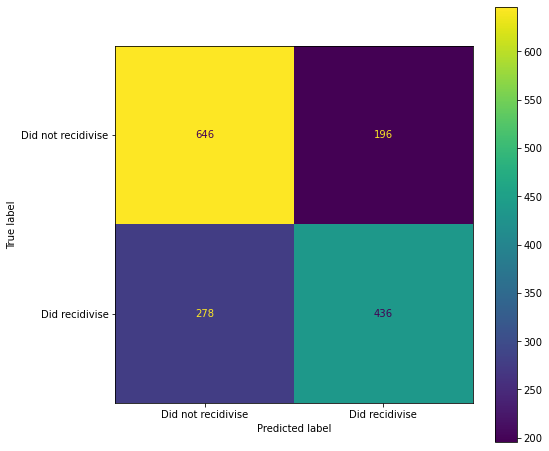

In [279]:
confusionmatrix(rfc, X_test, y_test, y_pred)

In [280]:
#Accuracy on test set
print(f"The predictive accuracy of Random Forest is: {accuracy_score(y_test, y_pred).round(2)}")

The predictive accuracy of Random Forest is: 0.7


Compared to linear models, Random Forest model after tuning increased the accuracy by 1%. 

True Negative Rate also increased by 3%, meaning that the RF model is also clearly better at predicting the people that did not recidivate that people that actually did. 

The type 1 error with Random Forest also decreased by 2%, meaning that with Random Forest we managed to make less inaccurate predictions about the people who did recidivate.

### <a name="ROC-AUC"></a>ROC Curve and AUC Score 

The AUC of our model is: 0.7457667152371638


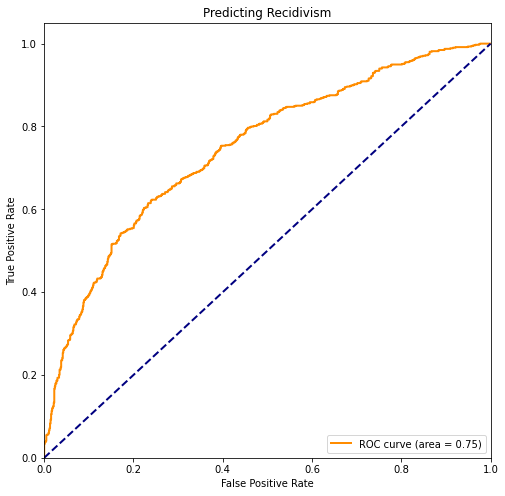

In [240]:
# Compute area under the curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("The AUC of our model is: {}".format(roc_auc_score(y_test, y_pred_prob)))

#Set default figure size
plt.rcParams['figure.figsize'] = (8,8)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Predicting Recidivism")
plt.legend(loc="lower right")
plt.show()

### <a name="Gini"></a>Model-Specific Feature Importance (Gini Impurity)  

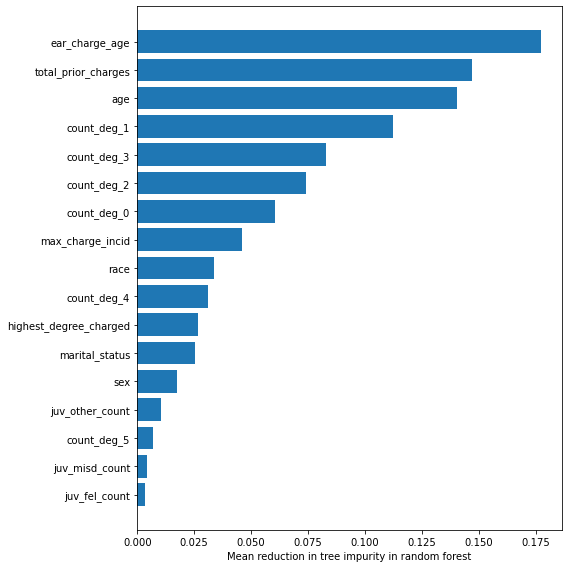

In [241]:
# Feature importance dataframe
imp_df = pd.DataFrame({'feature': X_train.columns.values,
                       'importance': rfc.feature_importances_})
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)
 
## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))
''
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Mean reduction in tree impurity in random forest")

plt.tight_layout()
# Show graphic
plt.show()

With the Gini Index as the measure for feature importance, we can see that Age at the 1st Charge, Age and Total Prior Charges are the most prominent factors for our model.

### <a name="pdp"></a>Partial Dependence Plot 

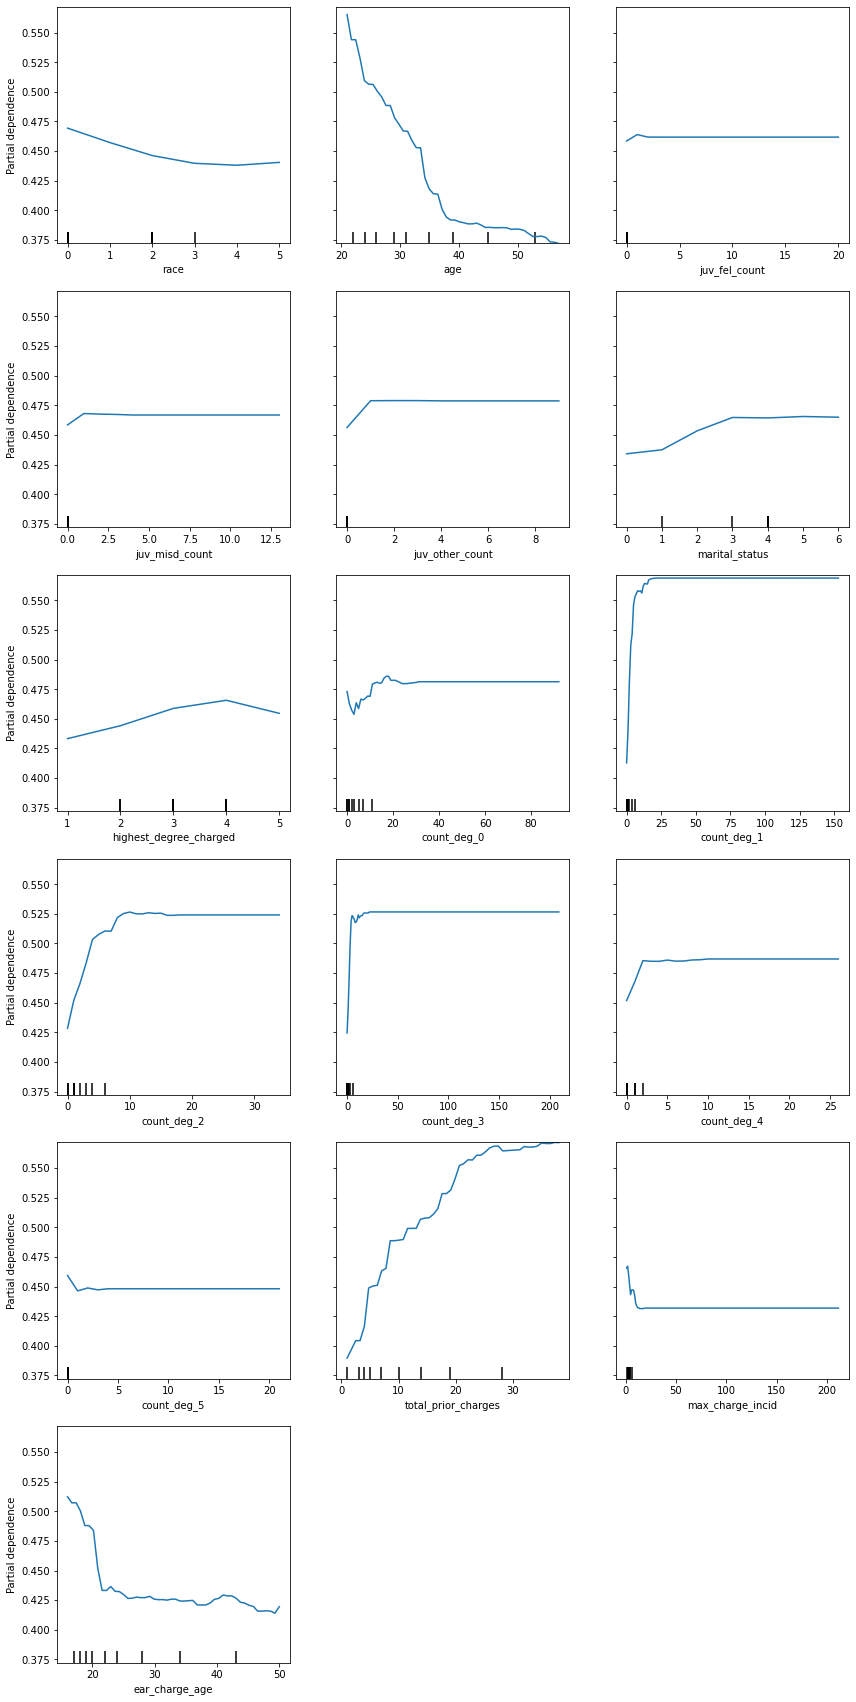

In [242]:
from sklearn.inspection import partial_dependence, plot_partial_dependence, PartialDependenceDisplay

features = X_train.columns
display = plot_partial_dependence(rfc, X_train, features[1:17], n_jobs=11 ,grid_resolution=50, kind="average")
plt.subplots_adjust(top = 3, right = 1.5)

Looking at the PDP, we can see that for Age, Total Prior Charge, Maximum Number of Charges and Number of Charge Degree 1, 2,3 have a considerably steep slope where the instances occur. This reasonate with the observations we deducted from the model-specific feature importance.

### <a name="SHAP"></a>SHAP Feature Importance 

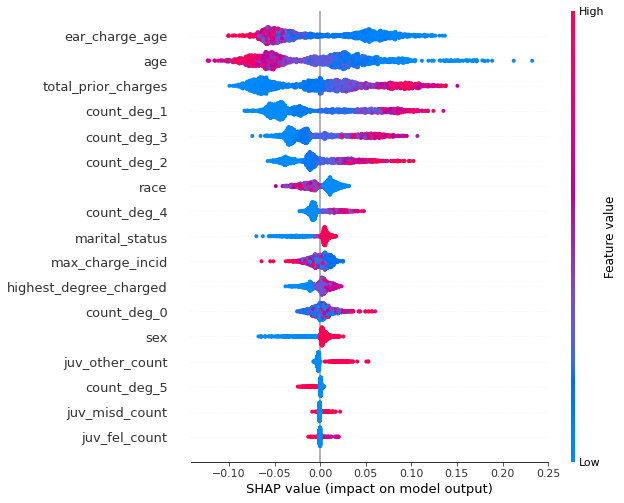

In [243]:
import shap

# explain the model's predictions on test set using SHAP values
# same syntax works for xgboost, LightGBM, CatBoost, and some scikit-learn models
explainer = shap.TreeExplainer(rfc)

# shap_values consists of a list of two matrices of dimension samplesize x #features
# The first matrix uses average nr of "is_recid = 0" as base value
# The second matrix which is used below uses average nr of "is_recid = 1" as base value 
shap_values = explainer.shap_values(X_test)

#A summary plot with the shapley value (feature importance) 
shap.summary_plot(shap_values[1], X_test)

The SHAP value of our features reinforce the importance of the 3 features: Age, Age at First Charge and Total Prior Charge. Unlike with Gini Index, Age overall is the most deciding factor here. Looking at the graph, we can conclude that while total_prior_charges has a positive correlation with whether a person would recidivate or not (meaning, the more charges they have, the more likely that they would recidivate), Age and Age at First Charge have a negative correlation, which means that younger people are more likely to recidivate. This conclustion makes sense because people who committed crime when they were young have more living time later on to recidivate, compared to someone who commmited something at the age of 50 for instance. Another argument from us is that, they could grow up in a criminal neighborhood and they are likely to be influenced by it. 

### <a name="effect-race"></a>The Effect of Race on Our Model 

In [281]:
X_test_copy = X_test.copy()

X_test_copy.head()

X_test_copy["predictions"] = y_pred #this is your actual predictions from the model not the probabilities
X_test_copy["true_values"] = y_test

X_test_copy.head()

X_test_copy.shape

X_rest = X_test_copy[(X_test_copy["race"] != 0)]

X_afr = X_test_copy[(X_test_copy["race"] == 0)]

# sanity check, the n_rows added need to equal the rows of X_test
print(X_afr.shape, X_rest.shape)

(822, 19) (734, 19)


In [282]:
#Creating function for the rates without plotting the confusion matrix

def confusion_matrix_rate(y_test, y_pred):
    conf_mat = pd.crosstab(y_pred, y_test)

    conf_mat

    tn = conf_mat[0][0]
    fp = conf_mat[0][1]
    fn = conf_mat[1][0]
    tp = conf_mat[1][1]

    print(tp, tn, fp, fn)

    fnr = fn/(fn+tp)

    fpr = fp/(fp+tn)

    tpr = tp/(tp+fn)

    tnr = tn/(tn+fp)

    ppv = tp/(tp+fp)

    npv = tn/(tn+fn)

    print(f"The False-negative-rate is {np.round(fnr, 2)}")
    print(f"The False-positive-rate is {np.round(fpr, 2)}")
    print(f"The Sensitivity or True-positive-rate is {np.round(tpr, 2)}")
    print(f"The Specitivity or True-negative-rate is {np.round(tnr, 2)}")
    print(f"The Positive-predictive value or precision is {np.round(ppv, 2)}")
    print(f"The Negative-predictive value or recall is {np.round(npv, 2)}")
    print(f"The Accuracy is {accuracy_score(y_test, y_pred).round(2)}")

In [283]:
# Confusion Matrix for African Americans
print("AFRICAN AMERICAN - With Race")
confusion_matrix_rate(X_afr["true_values"], X_afr["predictions"])

AFRICAN AMERICAN - With Race
301 277 126 118
The False-negative-rate is 0.28
The False-positive-rate is 0.31
The Sensitivity or True-positive-rate is 0.72
The Specitivity or True-negative-rate is 0.69
The Positive-predictive value or precision is 0.7
The Negative-predictive value or recall is 0.7
The Accuracy is 0.7


In [284]:
# Confusion Matrix for non-African Americans
print("NON AFRICAN-AMERICAN - With Race")

confusion_matrix_rate( X_rest["true_values"], X_rest["predictions"])

NON AFRICAN-AMERICAN - With Race
135 369 70 160
The False-negative-rate is 0.54
The False-positive-rate is 0.16
The Sensitivity or True-positive-rate is 0.46
The Specitivity or True-negative-rate is 0.84
The Positive-predictive value or precision is 0.66
The Negative-predictive value or recall is 0.7
The Accuracy is 0.69


Comparing the FNR, for black defendants it is 0.28 while for non-black it is 0.54 (almost doubled), which means that our model is more likely to predict that non-black defendants would not recidivate while they actually did. At the same time, the FPR for black (0.31) is much higher than for non-black (0.16), which proves the other point of the model being biasd against black since it falsely accused more black people than it did with non-black. This pattern is similar to what we have concluded from our Logistic Regression and also with what ProPublica found out with their analysis.

### <a name="model-without-race"></a>Model Without the Feature "Race" 

In [285]:
X_adj = X.drop(['race'], axis = 1)
X_adj.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,marital_status,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,total_prior_charges,max_charge_incid,ear_charge_age
0,1,69,0,0,0,4,3,4,0,1,1,0,0,6,2,62
1,1,34,0,0,0,4,3,0,0,0,1,0,0,1,1,31
2,1,24,0,0,1,4,3,6,3,6,4,0,0,19,5,17
5,1,44,0,0,0,2,2,0,0,1,0,0,0,1,1,42
6,1,41,0,0,0,4,4,4,3,4,13,3,0,27,4,19


Splitting our data into train and test sets with stratification

In [286]:
sum(y)/len(y)

X_train, X_test, y_train, y_test = train_test_split(X_adj, y ,random_state = 42, stratify = y)

sum(y_train)/len(y_train)

sum(y_test)/len(y_test)

0.4588688946015424

We fit the new data with the same hyperparameters we used in the beginning for our Random Forest model

In [287]:
rfc = RandomForestClassifier(n_estimators=90, max_depth=9, random_state=42, bootstrap=True, max_features='auto', min_samples_leaf=4, min_samples_split=9)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_pred_prob = rfc.predict_proba(X_test)[:,1]

Creating the Confusion Matrix

MODEL WITHOUT RACE
645 197 272 442
The Accuracy is 0.7
The False-negative-rate is 0.38
The False-positive-rate is 0.23
The Sensitivity or True-positive-rate is 0.62
The Specitivity or True-negative-rate is 0.77
The Positive-predictive value or precision is 0.69
The Negative-predictive value or recall is 0.7


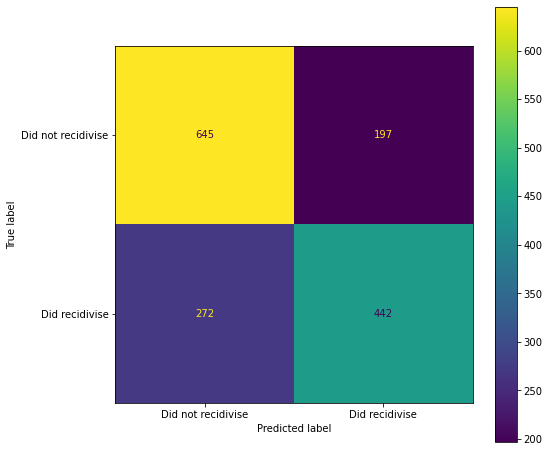

In [288]:
print("MODEL WITHOUT RACE")
confusionmatrix(rfc, X_test, y_test, y_pred)

We observed only minor changes to the rates when comparing them to the model with the feature "Race" at the beginning. The FNR has decreased by 1% while TPR has increased by 1%. Not considering Race, we were slightly better at predicting the people who would recidivate, and slightly made less mistakes when predicting people would not recidivate.<br>
However, the change is still very minor. Even when throwing out "Race" as a feature, the accuray did not improve significantly.

### <a name="effect-race-without-knowing"></a>The Effect of Race in Our Model Without It Knowing The Feature 

In [289]:
X_test_copy2 = X_test.copy()
X_test_copy2.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,marital_status,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,total_prior_charges,max_charge_incid,ear_charge_age
1664,0,24,0,0,0,4,3,0,1,0,1,0,0,2,1,19
2220,1,41,0,0,0,1,4,0,0,3,0,1,0,4,4,39
2023,1,35,0,0,0,4,2,2,2,1,0,0,0,5,2,22
1927,1,43,0,0,0,4,2,2,0,4,0,0,0,6,6,41
5421,1,27,0,0,0,4,2,4,2,1,0,0,0,7,3,20


Given the fact that we used the same random state for the classification, we can now use the features related to race and add them again to see how affected they were independent of the model knowing about the race.

In [290]:
X_test_copy2["race"] = X_test_copy["race"]
X_test_copy2.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,marital_status,highest_degree_charged,count_deg_0,count_deg_1,count_deg_2,count_deg_3,count_deg_4,count_deg_5,total_prior_charges,max_charge_incid,ear_charge_age,race
1664,0,24,0,0,0,4,3,0,1,0,1,0,0,2,1,19,0
2220,1,41,0,0,0,1,4,0,0,3,0,1,0,4,4,39,3
2023,1,35,0,0,0,4,2,2,2,1,0,0,0,5,2,22,0
1927,1,43,0,0,0,4,2,2,0,4,0,0,0,6,6,41,2
5421,1,27,0,0,0,4,2,4,2,1,0,0,0,7,3,20,0


Now we add back our predictions and true values for the model without race as a feature

In [291]:
X_test_copy2["predictions"] = y_pred
X_test_copy2["true_values"] = y_test

In [292]:
 X_test_copy2.shape

(1556, 19)

In [293]:
X_afr_2 = X_test_copy2[X_test_copy2["race"] == 0]
X_rest_2 = X_test_copy2[X_test_copy2["race"] != 0]

In [294]:
print(X_afr_2.shape, X_rest_2.shape)

(822, 19) (734, 19)


Looking at the shape of X_test_copy2 compared to X_afr and X_rest, we see that subsetting the datafram was successful.

Again, we will plot the Confusion Matrices for black and non-black defendants

In [295]:
# Confusion Matrix for African Americans
print("AFRICAN-AMERICAN - Without Race")

confusion_matrix_rate(X_afr_2["true_values"], X_afr_2["predictions"])

AFRICAN-AMERICAN - Without Race
294 287 116 125
The False-negative-rate is 0.3
The False-positive-rate is 0.29
The Sensitivity or True-positive-rate is 0.7
The Specitivity or True-negative-rate is 0.71
The Positive-predictive value or precision is 0.72
The Negative-predictive value or recall is 0.7
The Accuracy is 0.71


In [296]:
# Confusion Matrix for non-African Americans
print("NON AFRICAN-AMERICAN - Without Race")
confusion_matrix_rate(X_rest_2["true_values"], X_rest_2["predictions"])

NON AFRICAN-AMERICAN - Without Race
148 358 81 147
The False-negative-rate is 0.5
The False-positive-rate is 0.18
The Sensitivity or True-positive-rate is 0.5
The Specitivity or True-negative-rate is 0.82
The Positive-predictive value or precision is 0.65
The Negative-predictive value or recall is 0.71
The Accuracy is 0.69


Comparing these to the Confusion Matrix with the model knowing about the feature "Race", we observe the following:<br>
For African-American:<br>
FNR increased by 2% (from 0.28 to 0.3) <br>
FPR decreased by 2% (from 0.31 to 0.29)<br>
Precision increased by 2%<br>
--> Better at predicting recidivists, and more likely to predict wrongly people who would not recidivate

For Non-African-American:<br>
FNR decreased by 4% (from 0.54 to 0.5)<br>
FPR increased by 2% (from 0.18 to 0.16)<br>
Precision increased by 1%<br>
--> The opposite pattern is seen with non-African-American, meaning: Worse at predicting non-recidivists, and more likely to predict wrongly recidivists. 

In conclusion, Race as a feature did play a role and it had an effect on African-American. 

### <a name="predict-race"></a>Predict Race Based on Other Features

Since African Americans are still more likely to be wrongfully discriminated by the model despite the model now knowing the feature during the fit, we aussme that there exist features which do are caused by the race and thus still have an impact on the model picking up the race. We therefore tried an inverse approach and tried to predict race as a binary target.

Given that African-American is encoded 0 and the rest from 1-5, we will switch the encoding such that African-American = 1 and the rest 0

In [310]:
df_2 = df.copy()

In [311]:
df_2["race"] = df_2["race"].apply(lambda x: 1 if x == 0 else 0)

In [312]:
y_2 = df_2["race"]

X_2 = df_2.drop(['is_recid', 'is_violent_recid', 'two_year_recid', "race"], axis = 1)

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

In [314]:
rfc = RandomForestClassifier(n_estimators=90, max_depth=9, random_state=42, bootstrap=True, max_features='auto', min_samples_leaf=4, min_samples_split=9)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_pred_prob = rfc.predict_proba(X_test)[:,1]

Feature importance with Gini

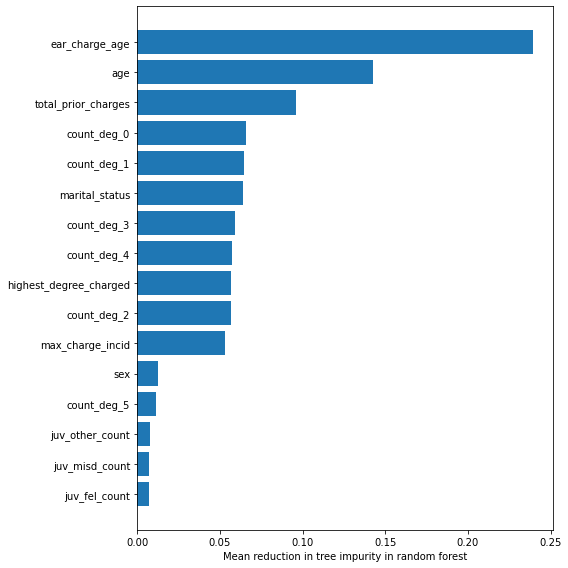

In [315]:
# Feature importance dataframe
imp_df = pd.DataFrame({'feature': X_train.columns.values,
                       'importance': rfc.feature_importances_})
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)
 
## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))
''
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Mean reduction in tree impurity in random forest")

plt.tight_layout()
# Show graphic
plt.show()

Feature Importance when predicting someone is black with SHAP

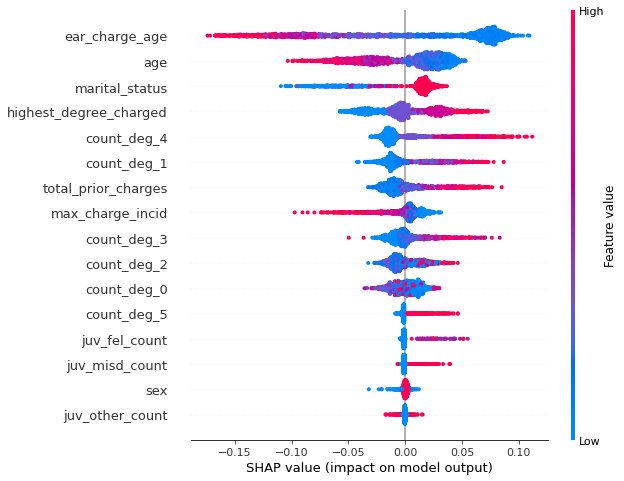

In [316]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

671 494 401 301
The False-negative-rate is 0.31
The False-positive-rate is 0.45
The Sensitivity or True-positive-rate is 0.69
The Specitivity or True-negative-rate is 0.55
The Positive-predictive value or precision is 0.63
The Negative-predictive value or recall is 0.62
The Accuracy is 0.62


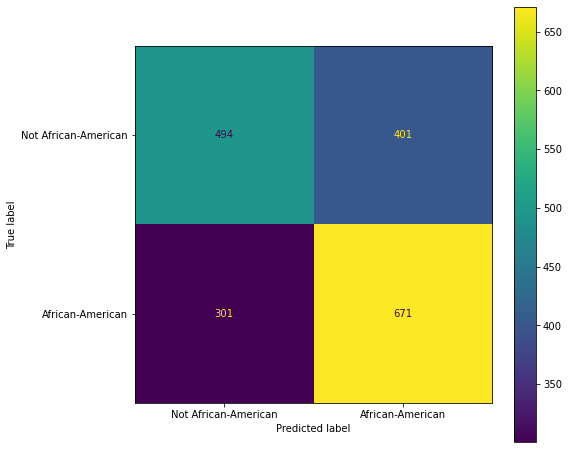

In [309]:
conf_mat_log = plot_confusion_matrix(rfc,
                     X_test,
                     y_test,
                      values_format='d',
                     display_labels=["Not African-American","African-American"])

confusion_matrix_rate(y_test, y_pred)

Using the same Random Forest Classifier with the same set of features (except for Race), we are able to predict if someone is African-American with an 62% accuracy. This confirmed our assumption that the other features in the model, despite not being related to race, were still racially biased. When predicting race African-American, the 2 most deciding factors are Age and Age at First Charge. This mean that the younger you are and the earlier you committed a crime, the more likly you are African-American. 